# Air Quality Analysis using PySpark

This project focuses on analyzing air quality data using PySpark and Pandas, two popular libraries in the field of data processing and analysis. The dataset used for this project is the "Air Quality Dataset Hourly averaged responses from an array of 5 metal oxide chemical sensors" available on Kaggle.

## Dataset Description

The "Air Quality Dataset Hourly averaged responses from an array of 5 metal oxide chemical sensors" contains hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The data was collected in a controlled chamber with a gas analyser reference device and 5 metal oxide chemical sensors. The goal is to estimate the relative humidity and temperature values based on the response of the chemical sensors.

0) Date (DD/MM/YYYY)
1) Time (HH.MM.SS)
2) True hourly averaged concentration CO in mg/m^3 (reference analyzer)
3) PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
4) True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
5) True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
6) PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
7) True hourly averaged NOx concentration in ppb (reference analyzer)
8) PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
9) True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
10) PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
11) PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
12) Temperature in Â°C
13) Relative Humidity (%)
14) AH Absolute Humidity

More Notes:

- GT = Global Throposphere

## Project Overview

This project follows a modular approach, with separate files for data preprocessing, data analysis, and model development. The main focus is on utilizing PySpark to preprocess the data, perform exploratory data analysis, and build a machine learning model for predicting air quality parameters.

The project involves the following steps:

1. **Data Preprocessing**: In this step, the raw dataset is cleaned, transformed, and prepared for further analysis. Data cleaning involves handling missing values, removing duplicates, and addressing any inconsistencies in the data. Feature engineering techniques may be applied to extract relevant information.

2. **Data Analysis**: Once the data is preprocessed, exploratory data analysis techniques are applied using Pandas and Plotly. Various statistical measures, visualizations, and insights are derived to understand the characteristics and patterns present in the dataset. This step helps in gaining a deeper understanding of the air quality data.

3. **Model Development**: After the data analysis, a machine learning model is developed using PySpark. The model is trained on the preprocessed dataset to predict air quality parameters such as relative humidity and temperature. Different algorithms, such as regression or classification models, can be explored and evaluated based on their performance metrics.

By following this modular approach, the project aims to provide a comprehensive understanding of the air quality dataset and enable accurate predictions of air quality parameters using machine learning techniques.

Note: The code for this project, including the data preprocessing, analysis, and model development, can be found in the respective files in the project repository.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('air_polution')\
    .getOrCreate()

In [3]:
df = spark.read.csv('datasets/Air Quality.csv', inferSchema=True, header=True)
print(df.toPandas())

+----------+-------------------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+----+----+
|      Date|               Time|CO(GT)|PT08_S1(CO)|NMHC(GT)|C6H6(GT)|PT08_S2(NMHC)|NOx(GT)|PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|PT08_S5(O3)|   T|  RH|    AH|_c15|_c16|
+----------+-------------------+------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+----+----+
|10/03/2004|2023-06-28 18:00:00|   2.6|       1360|     150|    11.9|         1046|    166|        1056|    113|        1692|       1268|13.6|48.9|0.7578|null|null|
|10/03/2004|2023-06-28 19:00:00|   2.0|       1292|     112|     9.4|          955|    103|        1174|     92|        1559|        972|13.3|47.7|0.7255|null|null|
|10/03/2004|2023-06-28 20:00:00|   2.2|       1402|      88|     9.0|          939|    131|        1140|    114|        1555|       1074|11.9|54.0|0.7502|null|null|
|10/03/200

In [4]:
df = df.drop(*['_c15','_c16'])

In [5]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- CO(GT): double (nullable = true)
 |-- PT08_S1(CO): integer (nullable = true)
 |-- NMHC(GT): integer (nullable = true)
 |-- C6H6(GT): double (nullable = true)
 |-- PT08_S2(NMHC): integer (nullable = true)
 |-- NOx(GT): integer (nullable = true)
 |-- PT08_S3(NOx): integer (nullable = true)
 |-- NO2(GT): integer (nullable = true)
 |-- PT08_S4(NO2): integer (nullable = true)
 |-- PT08_S5(O3): integer (nullable = true)
 |-- T: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- AH: double (nullable = true)



# Data Transform

In [6]:
CONSTANT_MODULE_FILE = "module/airpolution_data_constant.py"

In [7]:
%%writefile {CONSTANT_MODULE_FILE}

LABEL_KEY = "T"
FEATURE_KEY = [
 'CO(GT)',
 'PT08_S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08_S2(NMHC)',
 'NOx(GT)',
 'PT08_S3(NOx)',
 'NO2(GT)',
 'PT08_S4(NO2)',
 'PT08_S5(O3)',
 'RH',
 'AH']

ALL_KEY = [
 'CO(GT)',
 'PT08_S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08_S2(NMHC)',
 'NOx(GT)',
 'PT08_S3(NOx)',
 'NO2(GT)',
 'PT08_S4(NO2)',
 'PT08_S5(O3)',
 'RH',
 'AH',
 'T']

def transformed_name(key):
    """Rename transformed features"""

    return key + "_tn"

def vectorize_name(key):
    """"Rename vectorize features"""

    return key + "_Vect"

Overwriting module/airpolution_data_constant.py


In [8]:
TRANSFORM_MODULE_FILE = "module/airpolution_data_transform.py"

In [9]:
%%writefile {TRANSFORM_MODULE_FILE}

import airpolution_data_constant
from pyspark.sql.functions import concat, date_format, col, to_timestamp, lit, to_date, when, mean, coalesce, avg, log
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
import numpy as np

_FEATURE_KEY = airpolution_data_constant.FEATURE_KEY
_LABEL_KEY = airpolution_data_constant.LABEL_KEY
_ALL_KEY = airpolution_data_constant.ALL_KEY

_transformed_name = airpolution_data_constant.transformed_name
_vectorize_name = airpolution_data_constant.vectorize_name


def change_time_format(inputs):
  """This Function Changing the time format"""

  df = inputs.withColumn('Time', date_format('Time', 'HH:mm:ss'))

  return df

def merge_date_time(inputs):
  """This Function Merging Date & Time Column"""

  datetime_col = concat(inputs.Date, lit(" "), inputs.Time)
  df = inputs.withColumn("datetime", to_timestamp(datetime_col, "dd/MM/yyyy HH:mm:ss"))

  return df

def clean_date_format(inputs):
  """This Function Fix Date & Time Type"""

  df = inputs.withColumn("Date", to_date("Date", "dd/MM/yyyy"))

  return df

def clean_outlier(inputs):
  """This Function clean outlier and fill it with mean"""

  df = inputs.replace(-200, None)

  for i in df.columns:
    if i not in ["Date","Time","datetime"]:
 
      mean_col_value = df.select(mean(col(i))).collect()[0][0]

      df = df.na.fill(mean_col_value, i)

  return df

def drop_duplicate(inputs):
  """This Function deleting duplicate value in dataframe"""

  df = inputs.dropDuplicates()

  return df

def data_distribution(inputs):
  """This function transforms the data distribution"""

  column_transform_type = {
      'CO(GT)': 'Log',
      'PT08_S1(CO)': 'Reciprocal',
      'NMHC(GT)': 'Log',
      'C6H6(GT)': 'Log',
      'PT08_S2(NMHC)': 'Log',
      'NOx(GT)': 'Log',
      'PT08_S3(NOx)': 'Log',
      'NO2(GT)': 'Original',
      'PT08_S4(NO2)': 'Original',
      'PT08_S5(O3)': 'Log',
      'T': 'Original',
      'RH': 'Original',
      'AH': 'Original'
  }

  transformed_df = inputs

  for col_name, transform_type in column_transform_type.items():
      if transform_type == "Log":
          transformed_df = transformed_df.withColumn(col_name, log(col(col_name)))
      elif transform_type == "Reciprocal":
          transformed_df = transformed_df.withColumn(col_name, 1 / col(col_name))

  return transformed_df

def normalize_data(inputs):
    """Normalize the data"""

    column_to_remove = ['Date', 'Time', 'datetime']
    column_to_use = [i for i in inputs.columns if i not in column_to_remove]

    df = inputs

    for column in column_to_use:
        assembler = VectorAssembler(inputCols=[column], outputCol=_vectorize_name(column))
        minmax = MinMaxScaler(inputCol=_vectorize_name(column), outputCol=_transformed_name(column))
        pipeline = Pipeline(stages=[assembler, minmax])
        df = pipeline.fit(df).transform(df).drop(_vectorize_name(column))

    return df

def preprocessing_fn(inputs, dist_transform=False, normalize=False):
  """Main Function"""
  
  df = change_time_format(inputs)
  df = merge_date_time(df)
  df = clean_date_format(df)
  df = clean_outlier(df)
  df = drop_duplicate(df)

  if dist_transform:
    df = data_distribution(df)

  if normalize:
    df = normalize_data(df)

  return df

Overwriting module/airpolution_data_transform.py


Transform file do cleaning the null data, outlier data, time format, normalizing data and distribution transform that will be feed for the model development.

In [10]:
import sys

sys.path.append("C:\\Users\\Mario\\Documents\\data analyst projs\\pyspark_airpolution\\module")

In [11]:
import airpolution_data_transform

df_processing = airpolution_data_transform.preprocessing_fn(df)

In [12]:
df_processing.describe().show()

+-------+--------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|summary|    Time|            CO(GT)|       PT08_S1(CO)|         NMHC(GT)|          C6H6(GT)|    PT08_S2(NMHC)|           NOx(GT)|      PT08_S3(NOx)|           NO2(GT)|      PT08_S4(NO2)|       PT08_S5(O3)|                T|                RH|                 AH|
+-------+--------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|  count|    9357|              9357|              9357|             9357|              9357|             9357|              9357|              9357|              9357|              9357|              9357|  

In [13]:
df_processing.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- CO(GT): double (nullable = false)
 |-- PT08_S1(CO): integer (nullable = true)
 |-- NMHC(GT): integer (nullable = true)
 |-- C6H6(GT): double (nullable = false)
 |-- PT08_S2(NMHC): integer (nullable = true)
 |-- NOx(GT): integer (nullable = true)
 |-- PT08_S3(NOx): integer (nullable = true)
 |-- NO2(GT): integer (nullable = true)
 |-- PT08_S4(NO2): integer (nullable = true)
 |-- PT08_S5(O3): integer (nullable = true)
 |-- T: double (nullable = false)
 |-- RH: double (nullable = false)
 |-- AH: double (nullable = false)
 |-- datetime: timestamp (nullable = true)



In [14]:
df_processing.show()

+----------+--------+------------------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+-------------------+
|      Date|    Time|            CO(GT)|PT08_S1(CO)|NMHC(GT)|C6H6(GT)|PT08_S2(NMHC)|NOx(GT)|PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|PT08_S5(O3)|   T|  RH|    AH|           datetime|
+----------+--------+------------------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+-------------------+
|2004-03-11|07:00:00|               1.1|       1144|      29|     3.2|          667|     98|        1490|     82|        1339|        730|10.2|59.6|0.7417|2004-03-11 07:00:00|
|2004-03-14|14:00:00|               1.8|       1207|      84|     7.5|          879|    103|        1104|    102|        1490|        872|21.4|30.2|0.7616|2004-03-14 14:00:00|
|2004-03-15|09:00:00|               8.1|       1961|     618|    36.7|         1701|    478|         537|    149|       

# Data Analysist

## Importing Library

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib inline

In [16]:
analys_df = df_processing.toPandas()

c:\Users\Mario\anaconda3\envs\bigdata_env\lib\site-packages\pyspark\sql\pandas\conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [17]:
analys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   object        
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08_S1(CO)    9357 non-null   int32         
 4   NMHC(GT)       9357 non-null   int32         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08_S2(NMHC)  9357 non-null   int32         
 7   NOx(GT)        9357 non-null   int32         
 8   PT08_S3(NOx)   9357 non-null   int32         
 9   NO2(GT)        9357 non-null   int32         
 10  PT08_S4(NO2)   9357 non-null   int32         
 11  PT08_S5(O3)    9357 non-null   int32         
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
 15  datetime       9357 n

In [18]:
analys_df.sort_values(['datetime'])

Date      Time  CO(GT)  PT08_S1(CO)  NMHC(GT)  C6H6(GT)  \
2504  2004-03-10  18:00:00     2.6         1360       150      11.9   
2458  2004-03-10  19:00:00     2.0         1292       112       9.4   
5009  2004-03-10  20:00:00     2.2         1402        88       9.0   
6720  2004-03-10  21:00:00     2.2         1376        80       9.2   
5069  2004-03-10  22:00:00     1.6         1272        51       6.5   
...          ...       ...     ...          ...       ...       ...   
499   2005-04-04  10:00:00     3.1         1314       218      13.5   
9007  2005-04-04  11:00:00     2.4         1163       218      11.4   
1237  2005-04-04  12:00:00     2.4         1142       218      12.4   
6265  2005-04-04  13:00:00     2.1         1003       218       9.5   
828   2005-04-04  14:00:00     2.2         1071       218      11.9   

      PT08_S2(NMHC)  NOx(GT)  PT08_S3(NOx)  NO2(GT)  PT08_S4(NO2)  \
2504           1046      166          1056      113          1692   
2458            955      103          1174       92          1559   
5009            939      131          1140      114          1555   
6720            948      172          1092      122          1584   
5069            836      131          1205      116          1490   
...             ...      ...           ...      ...           ...   
499            1101      472           539      190          1374   
9007           1027      353           604      179          1264   
1237           1063      293           603      175          1241   
6265            961      235           702      156          1041   
828            1047      265           654      168          1129   

      PT08_S5(O3)     T    RH      AH            datetime  
2504         1268  13.6  48.9  0.7578 2004-03-10 18:00:00  
2458          972  13.3  47.7  0.7255 2004-03-10 19:00:00  
5009         1074  11.9  54.0  0.7502 2004-03-10 20:00:00  
6720         1203  11.0  60.0  0.7867 2004-03-10 21:00:00  
5069         1110  11.2  59.6  0.7888 2004-03-10 22:00:00  
...           ...   ...   ...     ...                 ...  
499          1729  21.9  29.3  0.7568 2005-04-04 10:00:00  
9007         1269  24.3  23.7  0.7119 2005-04-04 11:00:00  
1237         1092  26.9  18.3  0.6406 2005-04-04 12:00:00  
6265          770  28.3  13.5  0.5139 2005-04-04 13:00:00  
828           816  28.5  13.1  0.5028 2005-04-04 14:00:00  

[9357 rows x 16 columns]

## Pairplot Analysis

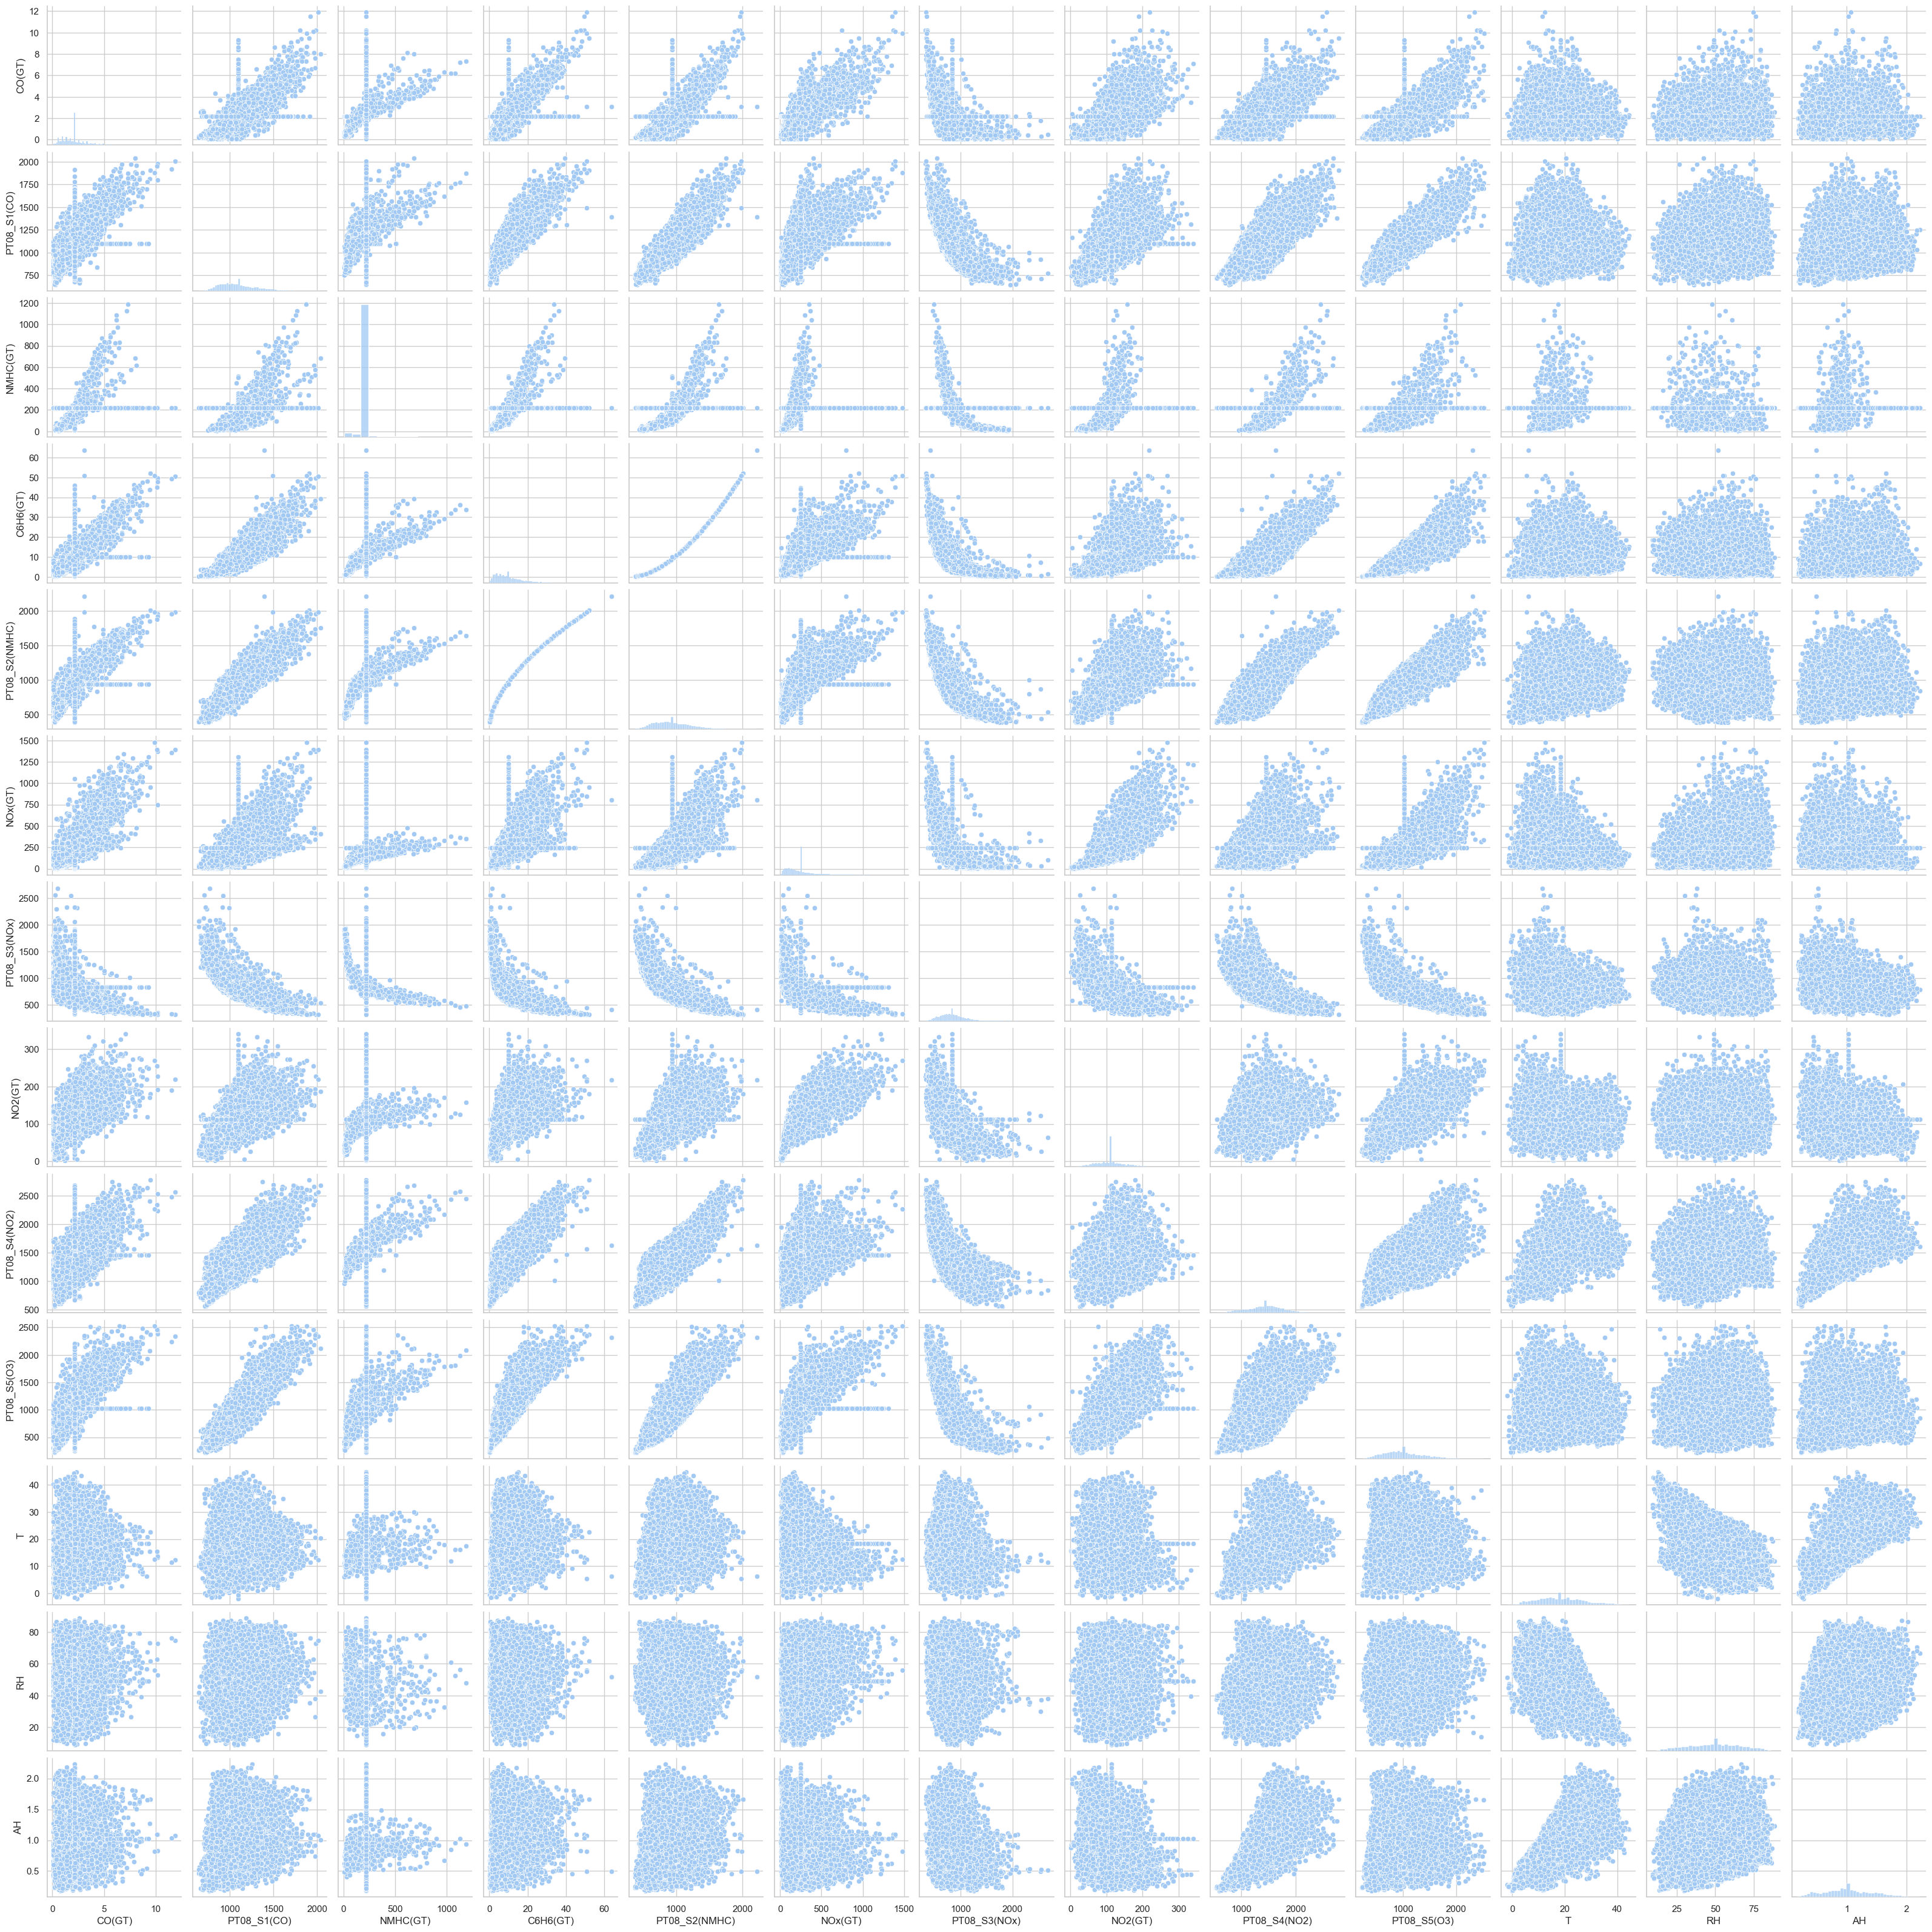

In [19]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.pairplot(analys_df)

From the pairplot we can see there are some data that looks flat like NMHC(GT), that flat data are the outlier data that already been change with the mean value, since the outlier has being plot againts each other column the result is give us the flat data that we can look in the pairplot.

C:\Users\Mario\AppData\Local\Temp\ipykernel_5268\2897492761.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(analys_df.corr(method="spearman"), annot=True)


<Axes: >

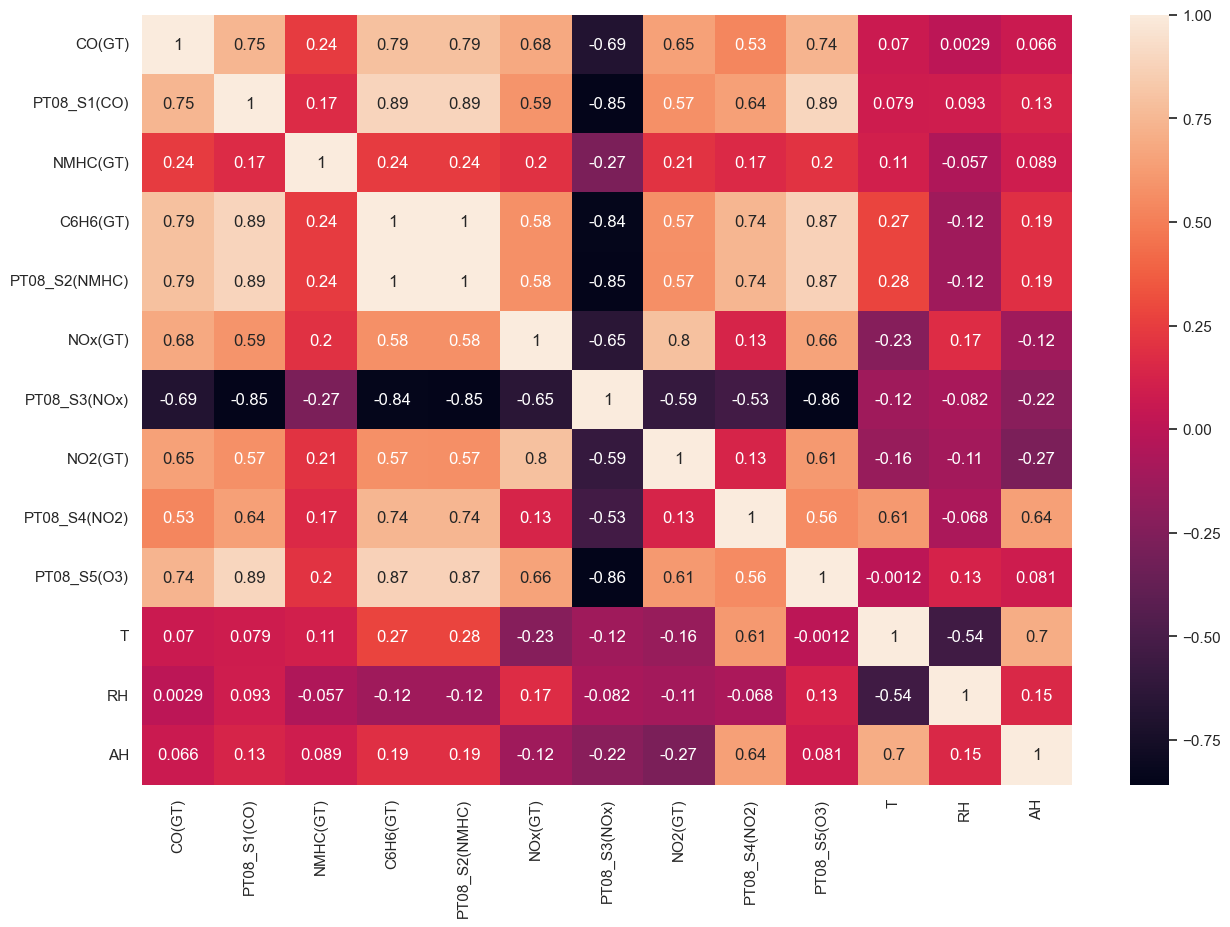

In [20]:
plt.figure(figsize=(15,10))
sns.heatmap(analys_df.corr(method="spearman"), annot=True)

From the pairplot above we know that:

- Benzene has correlation with another columns except CO(GT), NOx, T, RH, AH
- Carbon monokside has positive correlation with Benzene in the scale of global troposphere
- The only chemical measurements that has positive correlation is CO(GT) and PT08_S1 as the global troposphere distribute the data linear the same as the sensors data distributed
- Data in columns T, RH, AH does not show significant correlation to another columns
- using the pairplot we can know that the data has more left skewed distributed data.

## Forecast Analysis

In [21]:
df_monthly_avg = analys_df.groupby(analys_df['datetime'].dt.to_period('M')).mean()
df_monthly_avg = df_monthly_avg.reset_index()
df_monthly_avg['datetime'] = df_monthly_avg['datetime'].dt.strftime('%Y-%m')

C:\Users\Mario\AppData\Local\Temp\ipykernel_5268\2822327006.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly_avg = analys_df.groupby(analys_df['datetime'].dt.to_period('M')).mean()


In [22]:
fig = px.line(df_monthly_avg, x="datetime", y=df_monthly_avg.columns, title='Avg Monthly vs Variabels')
fig.show()

### monthly forecast average variables

- from the forecast above we know that NOx (Nitric Oxide) has higher value compared to other variables. 
- The highest value of benzene happend in oct 2004. 
- The highest value of carbon monoksida happend in dec 2004.
- The highest value of Non Metanic HydroCarbons happend in April 2004.
- the highest value of Nitrogen Oksida happend in Nov 2004.
- The highest value of Nitrogen Dioksida happend in Feb 2005.

## Checking data distributed

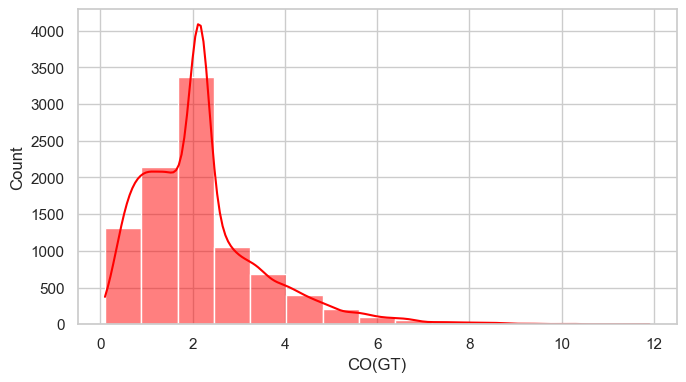

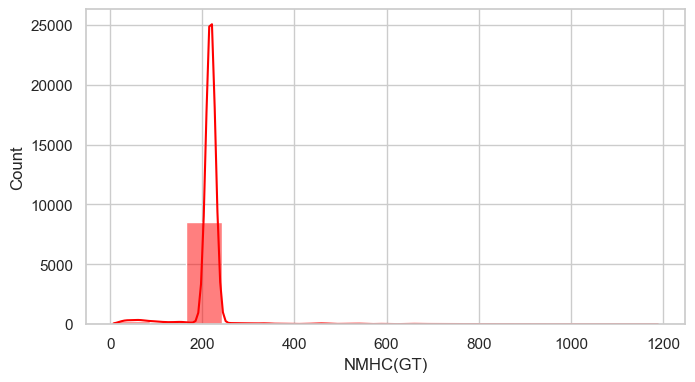

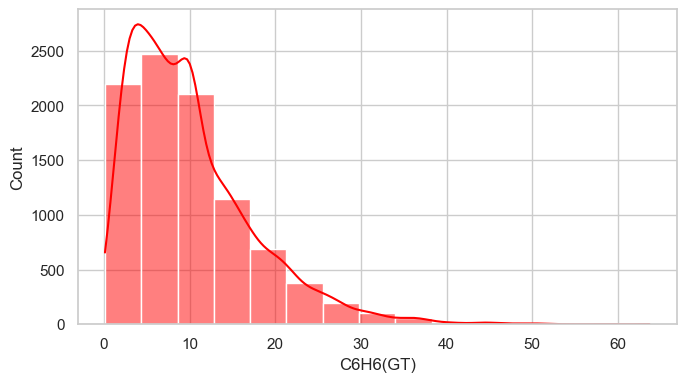

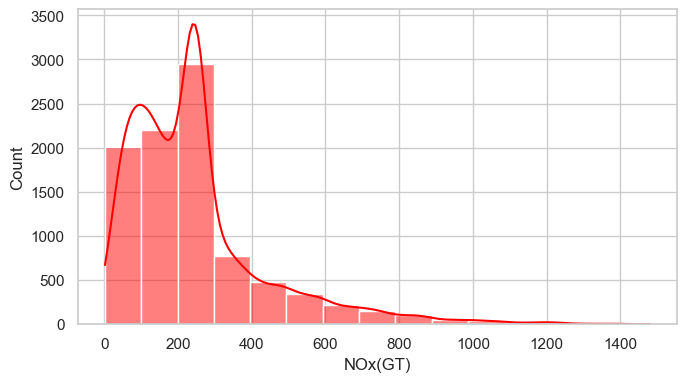

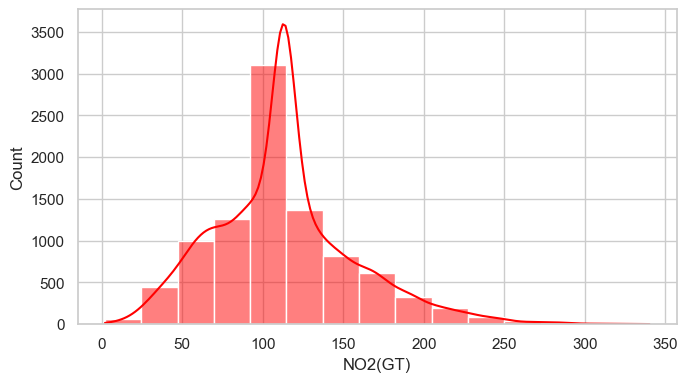

In [29]:
for i in analys_df.columns.drop(['Date','Time','datetime']):
    if "GT" in i:
        plt.figure(figsize=(17,9))
        plt.subplot(2,2,1)
        sns.histplot(x=analys_df[i],stat="count",color="red",bins=15,kde={'alpha':0.5})

From the histplot above we know that Nitro Oksida, Benzene, Carbon Monoksida has left skewed data.

c:\Users\Mario\anaconda3\envs\bigdata_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Mario\anaconda3\envs\bigdata_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


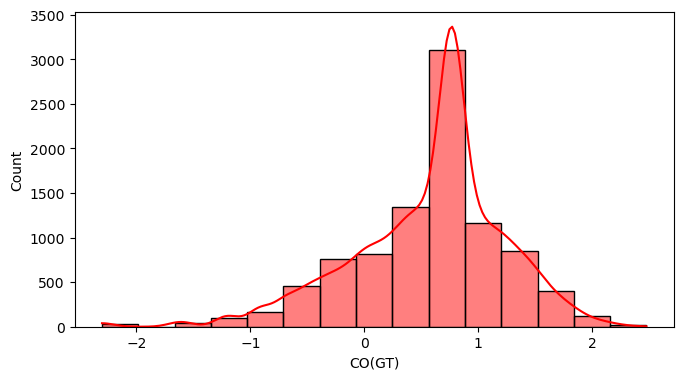

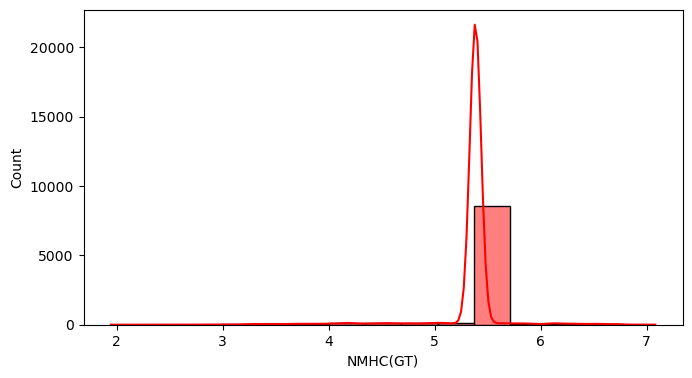

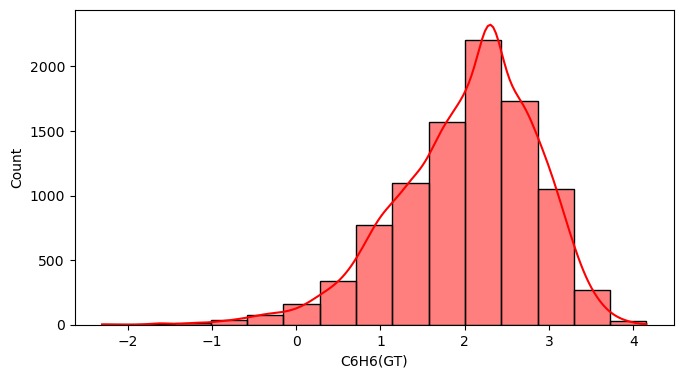

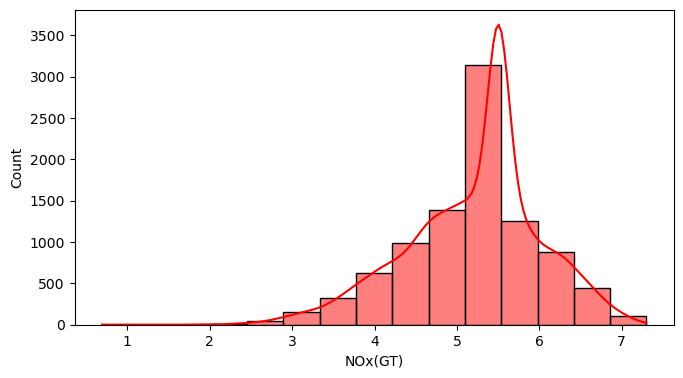

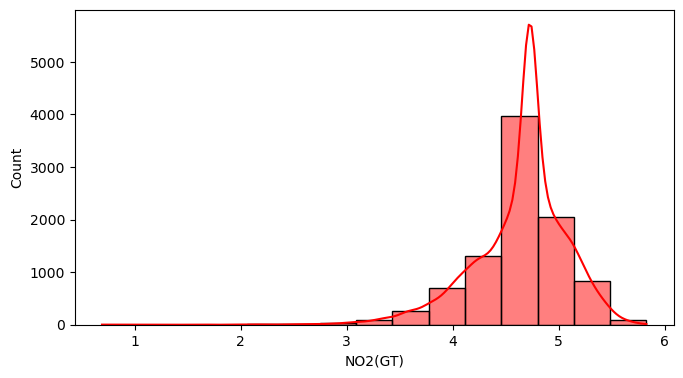

In [24]:
analys_df_log = analys_df[analys_df.columns.drop(['Date','Time','datetime'])].apply(lambda x: np.log(x))

for i in analys_df_log.columns:
    if "GT" in i:
        plt.figure(figsize=(17,9))
        plt.subplot(2,2,1)
        sns.histplot(x=analys_df_log[i],stat="count",color="red",bins=15,kde={'alpha':0.5})

The graph above shows the result of logaritmic data from non sensors

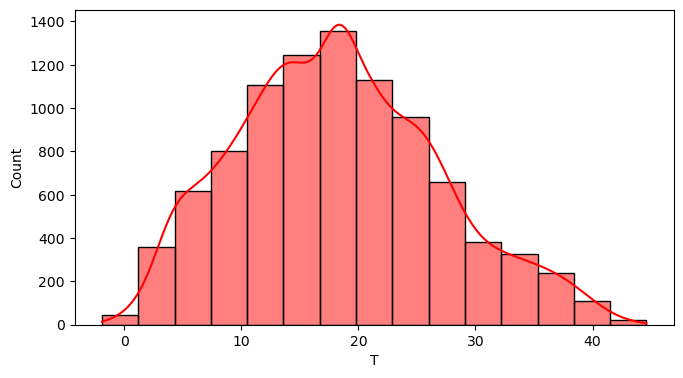

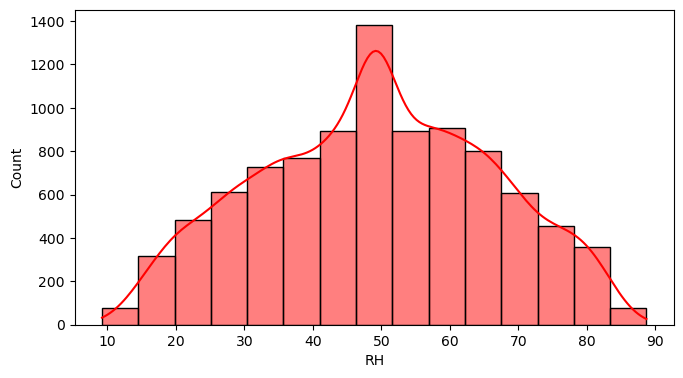

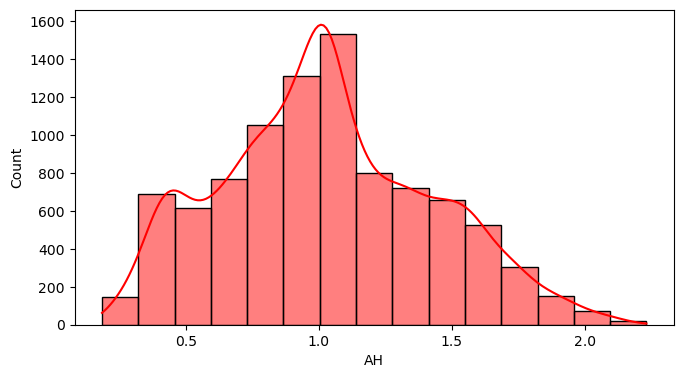

In [26]:
for i in ['T', 'RH', 'AH']:
    plt.figure(figsize=(17,9))
    plt.subplot(2,2,1)
    sns.histplot(x=analys_df[i],stat="count",color="red",bins=15,kde={'alpha':0.5})

From the hisplot above we know that AH and T has left skewed data distribution. RH has normal distributed data

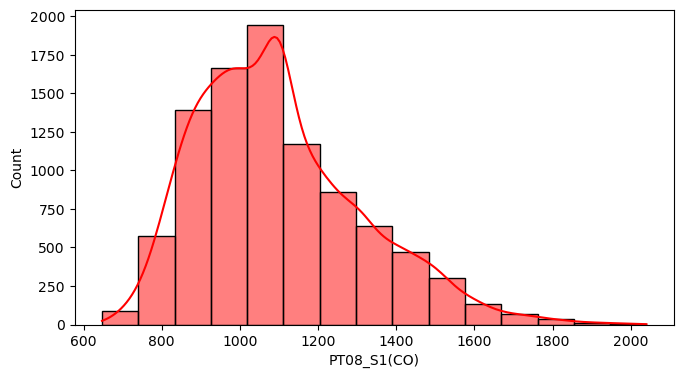

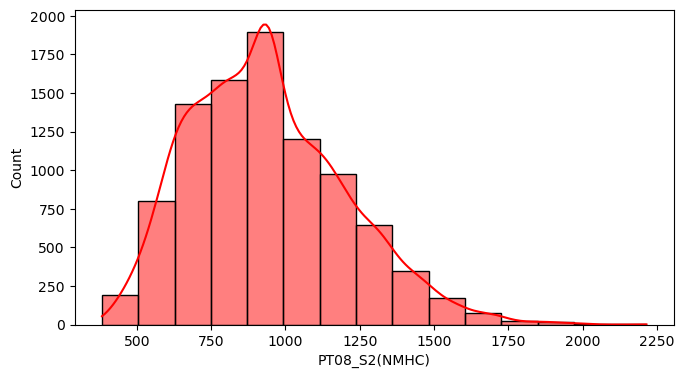

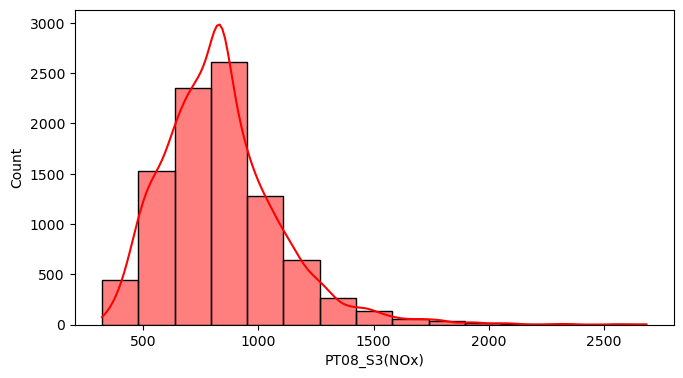

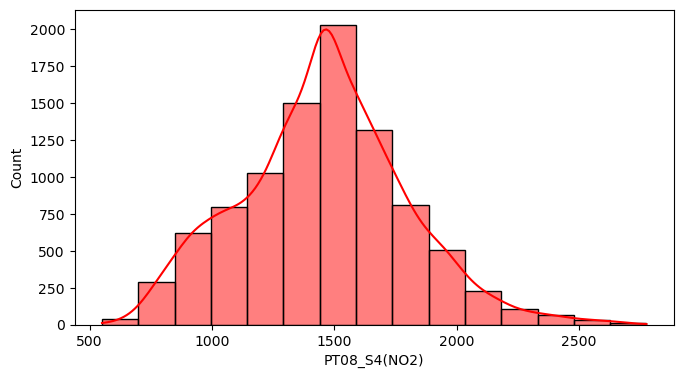

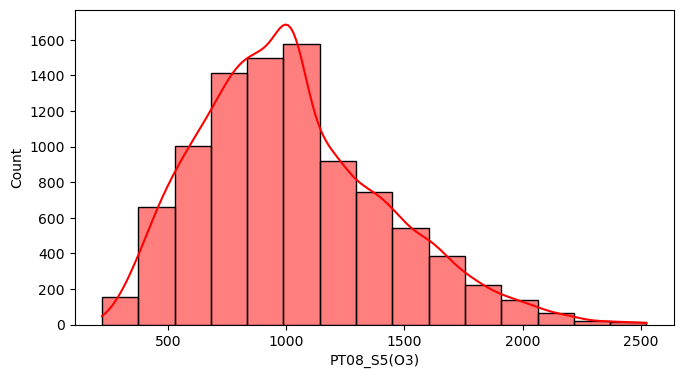

In [27]:
for i in analys_df.columns.drop(['Date','Time','datetime']):
    if "PT" in i:
        plt.figure(figsize=(17,9))
        plt.subplot(2,2,1)
        sns.histplot(x=analys_df[i],stat="count",color="red",bins=15,kde={'alpha':0.5})

From the histplot above we know that for sensors device data only PT08_S4(NO2) has normaly distributed data

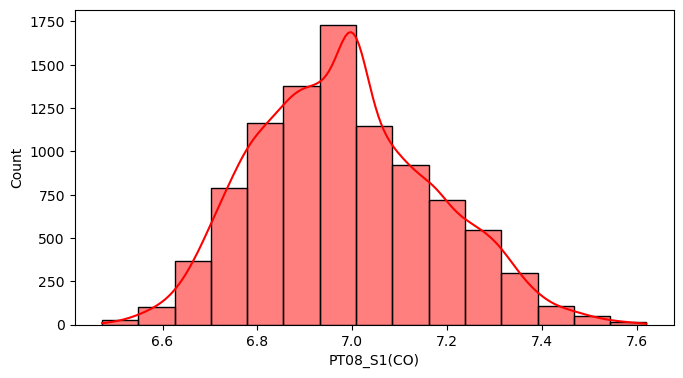

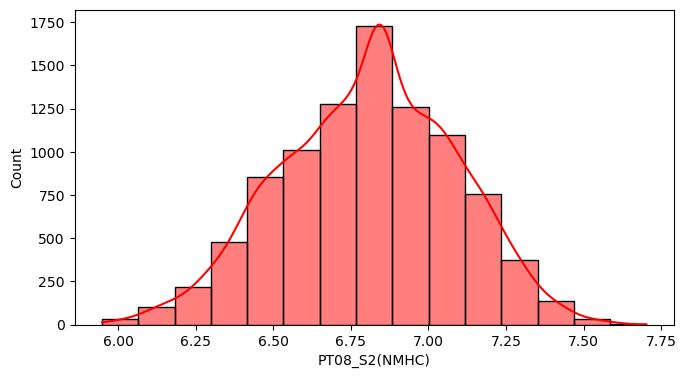

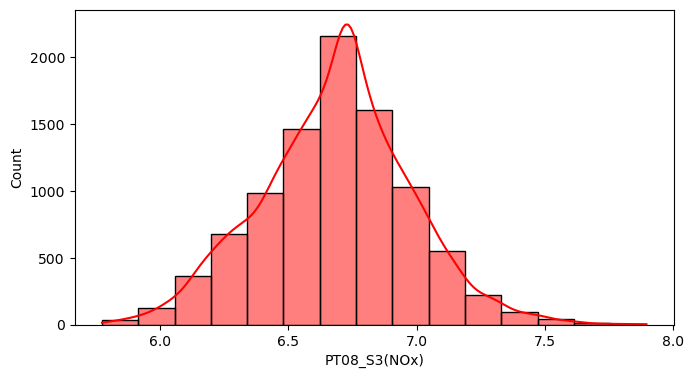

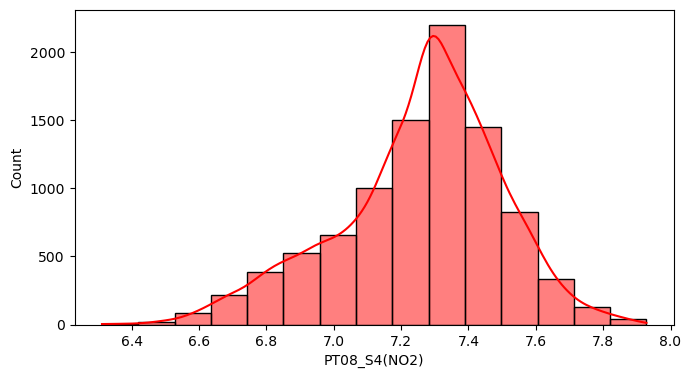

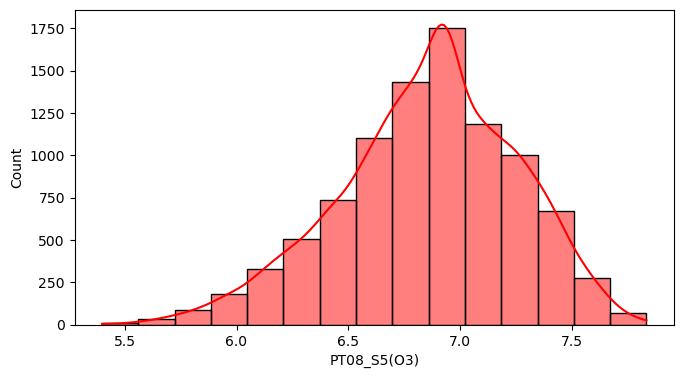

In [26]:
for i in analys_df_log.columns:
    if "PT" in i:
        plt.figure(figsize=(17,9))
        plt.subplot(2,2,1)
        sns.histplot(x=analys_df_log[i],stat="count",color="red",bins=15,kde={'alpha':0.5})

the graph above shows the logaritmic distribution data from sensors data

In [38]:
analys_df.skew()

C:\Users\Mario\AppData\Local\Temp\ipykernel_15636\2849351225.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  analys_df.skew()


CO(GT)           1.512462
PT08_S1(CO)      0.771593
NMHC(GT)         5.008751
C6H6(GT)         1.388959
PT08_S2(NMHC)    0.572947
NOx(GT)          1.891563
PT08_S3(NOx)     1.124152
NO2(GT)          0.685756
PT08_S4(NO2)     0.209617
PT08_S5(O3)      0.640784
T                0.315588
RH              -0.038692
AH               0.256452
dtype: float64

In [39]:
analys_df_recip = analys_df[analys_df.columns.drop(['Date','Time','datetime'])].apply(lambda x: 1/x)

analys_df_recip.skew()

CO(GT)            6.202992
PT08_S1(CO)       0.159924
NMHC(GT)         12.064475
C6H6(GT)         11.218489
PT08_S2(NMHC)     0.848054
NOx(GT)          13.742315
PT08_S3(NOx)      0.917047
NO2(GT)          22.574983
PT08_S4(NO2)      1.249215
PT08_S5(O3)       1.616393
T                      NaN
RH                2.123789
AH                2.022020
dtype: float64

In [27]:
analys_df_log.skew().sort_values(ascending=True)

NMHC(GT)        -3.573356
NO2(GT)         -1.120840
RH              -0.875294
CO(GT)          -0.769585
AH              -0.720641
C6H6(GT)        -0.708299
NOx(GT)         -0.523995
PT08_S4(NO2)    -0.513243
PT08_S5(O3)     -0.363414
PT08_S2(NMHC)   -0.126332
PT08_S3(NOx)     0.008279
PT08_S1(CO)      0.293085
T                     NaN
dtype: float64

In [57]:
result = {}

data_recip = analys_df_recip.skew()

data_log = analys_df_log.skew()

data_original = analys_df.drop(['Date','Time','datetime'],axis=1).skew()

for column in data_recip.index:
    value_recip = data_recip[column]
    value_log = data_log[column]
    value_original = data_original[column]
    
    min_value = min(abs(value_recip), abs(value_log), abs(value_original))
    
    if abs(value_recip) == min_value:
        result[column] = (value_recip, 'Reciprocal')
    elif abs(value_log) == min_value:
        result[column] = (value_log, 'Log')
    else:
        result[column] = (value_original, 'Original')
    
for column, (value, transform) in result.items():
    print(f'{column} ==> {value} ==> {transform}')


CO(GT) ==> -0.769584858170462 ==> Log
PT08_S1(CO) ==> 0.15992351605726565 ==> Reciprocal
NMHC(GT) ==> -3.5733557686337885 ==> Log
C6H6(GT) ==> -0.7082989847217865 ==> Log
PT08_S2(NMHC) ==> -0.1263324483352556 ==> Log
NOx(GT) ==> -0.5239951029625104 ==> Log
PT08_S3(NOx) ==> 0.008278588018567765 ==> Log
NO2(GT) ==> 0.6857556195692693 ==> Original
PT08_S4(NO2) ==> 0.2096173766279425 ==> Original
PT08_S5(O3) ==> -0.36341365031270195 ==> Log
T ==> 0.3155884763806343 ==> Original
RH ==> -0.03869203186717812 ==> Original
AH ==> 0.25645171136696526 ==> Original


In [63]:
column_transform = {}

for column, (value, transform) in result.items():
    column_transform[column] = transform

column_transform

{'CO(GT)': 'Log',
 'PT08_S1(CO)': 'Reciprocal',
 'NMHC(GT)': 'Log',
 'C6H6(GT)': 'Log',
 'PT08_S2(NMHC)': 'Log',
 'NOx(GT)': 'Log',
 'PT08_S3(NOx)': 'Log',
 'NO2(GT)': 'Original',
 'PT08_S4(NO2)': 'Original',
 'PT08_S5(O3)': 'Log',
 'T': 'Original',
 'RH': 'Original',
 'AH': 'Original'}

In [32]:
from scipy.stats import shapiro

for i in analys_df.columns.drop(['Date','Time','datetime']):
    p_vals = shapiro(analys_df[i])[1]
    sig_vals = shapiro(analys_df[i])[0]
    if p_vals < 0.05:
        print(f"[{i}] p-value: {p_vals}, signif-value {sig_vals}")

[CO(GT)] p-value: 0.0, signif-value 0.8922240734100342
[PT08_S1(CO)] p-value: 3.783505853677006e-44, signif-value 0.9615641236305237
[NMHC(GT)] p-value: 0.0, signif-value 0.30608034133911133
[C6H6(GT)] p-value: 0.0, signif-value 0.8967937231063843
[PT08_S2(NMHC)] p-value: 1.1544068402564529e-35, signif-value 0.9778857231140137
[NOx(GT)] p-value: 0.0, signif-value 0.8305597305297852
[PT08_S3(NOx)] p-value: 0.0, signif-value 0.9442952871322632
[NO2(GT)] p-value: 1.6675451725465323e-43, signif-value 0.9630635976791382
[PT08_S4(NO2)] p-value: 1.531480172573161e-21, signif-value 0.9926659464836121
[PT08_S5(O3)] p-value: 2.5989980708724885e-39, signif-value 0.9717391729354858
[T] p-value: 6.149836164993573e-28, signif-value 0.9874593615531921
[RH] p-value: 3.2198558663915922e-28, signif-value 0.9871805906295776
[AH] p-value: 4.135695920814417e-29, signif-value 0.9862651228904724


c:\Users\Mario\anaconda3\envs\bigdata_env\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


This process help us to choose what is the best method for handling the skewed data. Every column will calculated to determine what is the optimze distribution method that will be used for model development that in the end will be compared  model with data transformed and the raw data.

# Model Development

In [15]:
MODEL_MODULE_FILE = "module/airpolution_model_v1.py"

In [16]:
%%writefile {MODEL_MODULE_FILE}

import airpolution_data_constant
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

_FEATURE_KEY = airpolution_data_constant.FEATURE_KEY
_LABEL_KEY = airpolution_data_constant.LABEL_KEY
_ALL_KEY = airpolution_data_constant.ALL_KEY
FEATURE_KEY_TN = [
    'CO(GT)_tn',
    'PT08_S1(CO)_tn',
    'NMHC(GT)_tn',
    'C6H6(GT)_tn',
    'PT08_S2(NMHC)_tn',
    'NOx(GT)_tn',
    'PT08_S3(NOx)_tn',
    'NO2(GT)_tn',
    'PT08_S4(NO2)_tn',
    'PT08_S5(O3)_tn',
    'RH_tn',
    'AH_tn']


def transform_data(input, assembler):
    """Vectorizing the data"""

    print("Vectorizing the data")
    
    transformed = assembler.transform(input)
    return transformed

def splitting_data(input):
    """Splitting the data"""

    print("Splitting the data")
    (train_data, test_data) = input.randomSplit([0.8, 0.2])

    return (train_data, test_data)

def train_model(model, input):
    """Inputing model from user"""

    trained_model = model.fit(input)
    return trained_model

def eval_model(pred_model):
    """evaluate model"""

    rmse = RegressionEvaluator(labelCol=_LABEL_KEY, predictionCol="prediction", metricName="rmse")
    rmse = rmse.evaluate(pred_model)
    mae = RegressionEvaluator(labelCol=_LABEL_KEY, predictionCol="prediction", metricName="mae")
    mae = mae.evaluate(pred_model)
    r2 = RegressionEvaluator(labelCol=_LABEL_KEY, predictionCol="prediction", metricName="r2")
    r2 = r2.evaluate(pred_model)

    print("RMSE: ", rmse)
    print("MAE: ", mae)
    print("R-squared: ", r2)
    
def model_fn(model_list, input, assembler_transform):

    if assembler_transform:
            assembler = VectorAssembler(inputCols=FEATURE_KEY_TN, outputCol="features")
    else:
            assembler = VectorAssembler(inputCols=_FEATURE_KEY, outputCol="features")

    transformed_data = transform_data(input, assembler)
    train_data, test_data = splitting_data(transformed_data)
    
    for model in model_list:
        print("\n,", model)
        trained_model = train_model(model, train_data)
        pred_model = trained_model.transform(test_data)
        model_evaluation = eval_model(pred_model)
        print("\n")

    return trained_model


Overwriting module/airpolution_model_v1.py


In [17]:
import airpolution_model_v1
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

model_list = [
    DecisionTreeRegressor(labelCol="T", featuresCol="features"),
    RandomForestRegressor(labelCol="T", featuresCol="features")
]

df_model = airpolution_model_v1.model_fn(model_list, df, assembler_transform=False)

Vectorizing the data


Splitting the data

, DecisionTreeRegressor_4c8a8baa14c8
RMSE:  2.873588335180391
MAE:  2.241733756743419
R-squared:  0.9956220651287081



, RandomForestRegressor_c1bb308f0674
RMSE:  3.524948499588271
MAE:  2.6944294337508787
R-squared:  0.9934124223898312




## Model Development for distribution transformed data

In [18]:
df_processing_dist = airpolution_data_transform.preprocessing_fn(df, dist_transform=True)

In [19]:
df_processing_dist.show()

+----------+--------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------+------------+------------------+----+----+------+-------------------+
|      Date|    Time|              CO(GT)|         PT08_S1(CO)|          NMHC(GT)|          C6H6(GT)|     PT08_S2(NMHC)|           NOx(GT)|      PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|       PT08_S5(O3)|   T|  RH|    AH|           datetime|
+----------+--------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------+------------+------------------+----+----+------+-------------------+
|2004-03-11|07:00:00| 0.09531017980432493|8.741258741258741E-4| 3.367295829986474|1.1631508098056809| 6.502790045915623| 4.584967478670572| 7.306531398939505|     82|        1339| 6.593044534142437|10.2|59.6|0.7417|2004-03-11 07:00:00|
|2004-03-14|14:00:00|  0.5877866649021191|8.285004142502

In [20]:
import airpolution_model_v1
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

model_list = [
    DecisionTreeRegressor(labelCol="T", featuresCol="features"),
    RandomForestRegressor(labelCol="T", featuresCol="features")
]

df_model_transform = airpolution_model_v1.model_fn(model_list, df_processing_dist, assembler_transform=False)

Vectorizing the data
Splitting the data

, DecisionTreeRegressor_05fb392ef537
RMSE:  2.1010514893241146
MAE:  1.7132328864716941
R-squared:  0.9415494509096733



, RandomForestRegressor_975aad9cd693
RMSE:  2.8845030172402546
MAE:  2.257871719710507
R-squared:  0.8898315601129945




## Model Development for distribution normalize data

In [21]:
df_processing_normalize = airpolution_data_transform.preprocessing_fn(df, normalize=True)

In [22]:
df_processing_normalize.show()

+----------+--------+------------------+-----------+--------+--------+-------------+-------+------------+-------+------------+-----------+----+----+------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Date|    Time|            CO(GT)|PT08_S1(CO)|NMHC(GT)|C6H6(GT)|PT08_S2(NMHC)|NOx(GT)|PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|PT08_S5(O3)|   T|  RH|    AH|           datetime|           CO(GT)_tn|      PT08_S1(CO)_tn|         NMHC(GT)_tn|         C6H6(GT)_tn|    PT08_S2(NMHC)_tn|          NOx(GT)_tn|     PT08_S3(NOx)_tn|          NO2(GT)_tn|     PT08_S4(NO2)_tn|      PT08_S5(O3)_tn|                T_tn|               RH_tn|               AH_tn|
+----------+--------+------------------+-----------+--------+--------+-------------+-------+----------

In [23]:
import airpolution_model_v1
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

model_list = [
    DecisionTreeRegressor(labelCol="T", featuresCol="features"),
    RandomForestRegressor(labelCol="T", featuresCol="features")
]

df_model = airpolution_model_v1.model_fn(model_list, df_processing_normalize, assembler_transform=True)

Vectorizing the data
Splitting the data

, DecisionTreeRegressor_92d80f657443
RMSE:  2.044640645991832
MAE:  1.6443691591966
R-squared:  0.9455756805363574



, RandomForestRegressor_075e5636fb6d
RMSE:  2.7702104107851593
MAE:  2.1196213694982124
R-squared:  0.9000956171506417




## Model Development for log transform and normalize data

In [24]:
df_processing_dist_norm = airpolution_data_transform.preprocessing_fn(df, dist_transform=True, normalize=True)

In [25]:
df_processing_dist_norm.show()

+----------+--------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+-------+------------+------------------+----+----+------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      Date|    Time|              CO(GT)|         PT08_S1(CO)|          NMHC(GT)|          C6H6(GT)|     PT08_S2(NMHC)|           NOx(GT)|      PT08_S3(NOx)|NO2(GT)|PT08_S4(NO2)|       PT08_S5(O3)|   T|  RH|    AH|           datetime|           CO(GT)_tn|      PT08_S1(CO)_tn|         NMHC(GT)_tn|         C6H6(GT)_tn|    PT08_S2(NMHC)_tn|          NOx(GT)_tn|     PT08_S3(NOx)_tn|          NO2(GT)_tn|     PT08_S4(NO2)_tn|      PT08_S5(O3)_tn|                T_tn|               RH_tn|    

In [26]:
import airpolution_model_v1
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor

model_list = [
    DecisionTreeRegressor(labelCol="T", featuresCol="features"),
    RandomForestRegressor(labelCol="T", featuresCol="features")
]

df_model = airpolution_model_v1.model_fn(model_list, df_processing_normalize, assembler_transform=True)

Vectorizing the data
Splitting the data

, DecisionTreeRegressor_f408023cb757
RMSE:  2.1341901411776214
MAE:  1.7201617320661717
R-squared:  0.9374457065284536



, RandomForestRegressor_c187b1ee5ace
RMSE:  2.7504634164500135
MAE:  2.1283648685140153
R-squared:  0.8961030855030346




In [1]:
result_r2_json_decision = {
    "raw_model": 0.9956220651287081,
    "dist_trans_model": 0.9415494509096733,
    "norm_model": 0.9455756805363574,
    "dist_trans_norm_model": 0.9374457065284536
}

result_r2_json_random = {
    "raw_model": 0.9934124223898312,
    "dist_trans_model": 0.8898315601129945,
    "norm_model": 0.9000956171506417,
    "dist_trans_norm_model": 0.8961030855030346
}

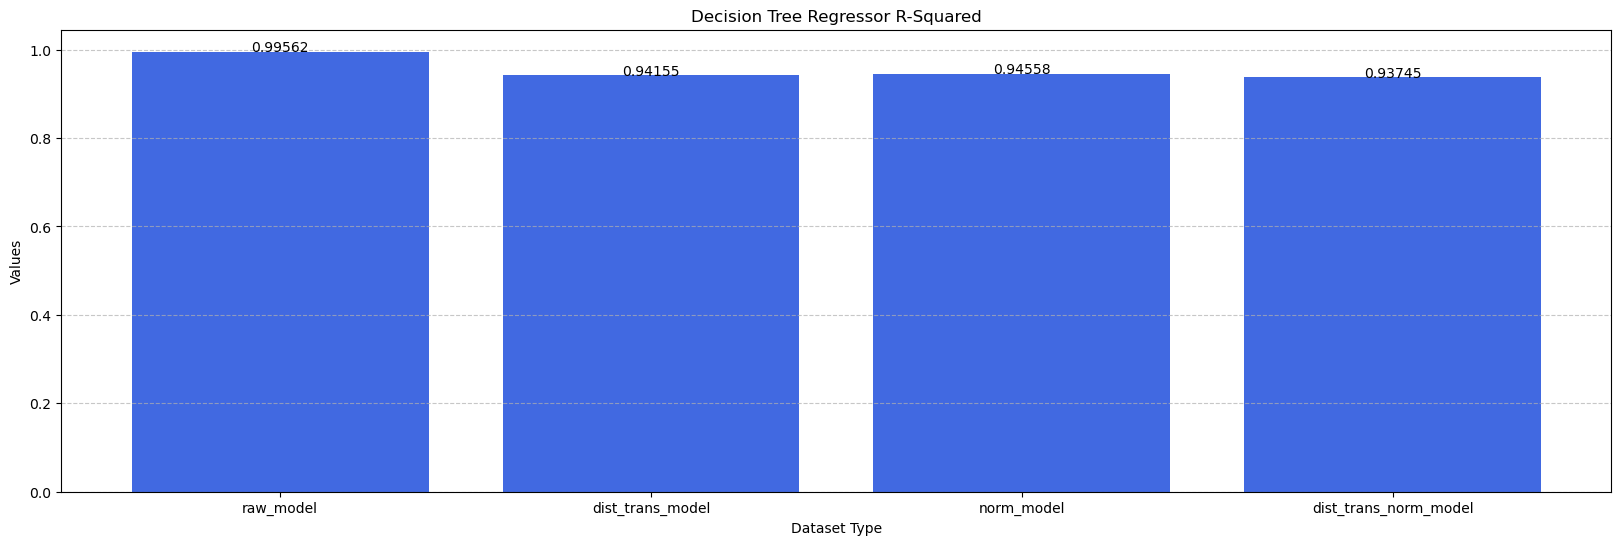

In [2]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(result_r2_json_decision.keys(), result_r2_json_decision.values(), color='royalblue')

for i, v in enumerate(result_r2_json_decision.values()):
    ax.text(i, v, f"{v:.5f}", ha='center', fontsize=10)

ax.set_title('Decision Tree Regressor R-Squared')
ax.set_xlabel('Dataset Type')
ax.set_ylabel('Values')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

From the graph above we can see that the raw data has the higher value of R-squared and the second highest value in norm_model Decision Tree Regressor model

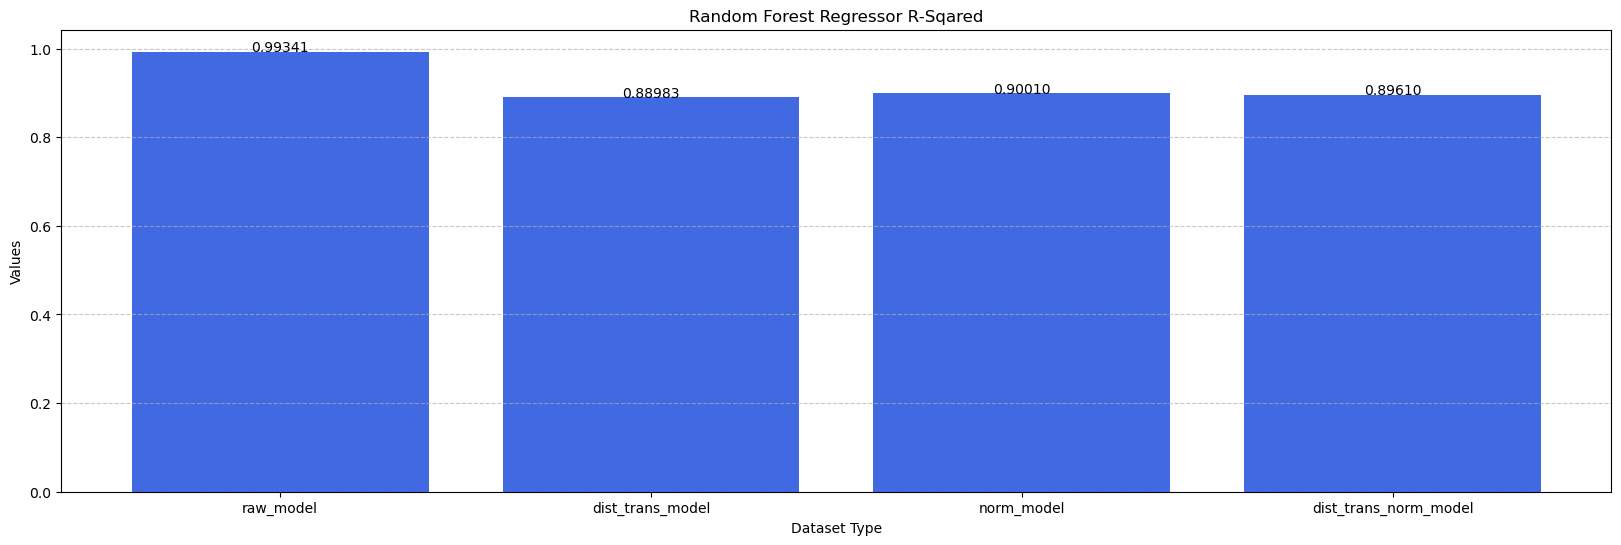

In [3]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(result_r2_json_random.keys(), result_r2_json_random.values(), color='royalblue')

for i, v in enumerate(result_r2_json_random.values()):
    ax.text(i, v, f"{v:.5f}", ha='center', fontsize=10)

ax.set_title('Random Forest Regressor R-Sqared')
ax.set_xlabel('Dataset Type')
ax.set_ylabel('Values')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

From the graph above we can see that the raw model has the highest value of R-squared and the norm_model has the second highest value from Random Forest Regressor model

# Conclusion

From this projects we know that raw data has the best performance based on the R-squared evalutaion matrix on both model, then the only normalize data sit on the second position.  